# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель:**

Построить модель, которая сможет максимально точно предсказывать, когда клиент собирается уйти, чтобы компания своевременно смогла предпринять меры.

**План работы:**

*Предобработка данных:*

 - Загрузить данные и провести первичный анализ
 - Изучить данные, визуализировать признаки
 - Проверить на мультиколлинеарность, при необходимости удалить некоторые из признаков
 - Проверить классы на несбалансированность
 
*Построение модели:*
 - Построить Pipeline, включить в него кодировку и scaling признаков
 - Подобрать лучшую модель и гиперпараметры через RandomizedGridSearch
 - Проверить модели на тествой выборке, анализ подучившейся метрики
 - Создать матрицу ошибок, проанализировать важность признаков
 
*Отчет по решению:*
 - Проанализировать, какие признаки оказались определяющими
 - Подвести итог, какая модель лучшая и с какими гиперпарамтерами
 - Предложить, как можно оптимизировать работу


## Исследовательский анализ данных

In [1]:

!pip install colorama
!pip install imblearn
!pip install phik

In [2]:
import pandas as pd
from colorama import Fore
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

%matplotlib inline



import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



import sklearn.metrics
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score

In [3]:
import warnings

warnings.filterwarnings('ignore')



In [4]:
RANDOM_STATE = 240423

In [5]:
#загружаем данные
try:
    data_personal = pd.read_csv('personal_new.csv')
    data_contract = pd.read_csv('contract_new.csv')
    data_internet = pd.read_csv('internet_new.csv')
    data_phone = pd.read_csv('phone_new.csv')
except:
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

**Personal**

 - SeniorCitizen - наличие пенсионного статуса
 - Partner - наличие супруга
 - Dependents - наличие иждивенцев


**Contract**

 - Type - тип оплаты услуг (каждый месяц, раз в месяц)
 - PaperlessBilling	-  электронный чек или бумажный
 - PaymentMethod - способ оплаты
 - MonthlyCharges - клиент ежемесячно платит
 - TotalCharges - всегог потрачено на услуги

**Internet**

 - InternetService - интернет подключение может быть двух типов: через телефонную линию (DSL, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*)
 
*Дополнительные услуги*:

 - DeviceProtection - антивирус
 - OnlineSecurity - блокировка небезопасных сайтов 
 - TechSupport - выделенная линия технической поддержки
 - OnlineBackup - облачное хранилище файлов для резервного копирования данных
 - StreamingTV  - стриминговое телевидение
 - StreamingMovies - каталог фильмов 

**Phone**

 - MultipleLines - возможность вести звонки на параллельных линиях

### Первичный анализ

In [6]:
datasets = {'Personal': data_personal,
'Contract':data_contract,
'Internet':data_internet,
'Phone':data_phone}

In [7]:
def general_info(data):
    display(data.head(5))
    print()
    print('Размеры датафрейма:', data.shape)
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество дубликатов в столбце id:', data['customerID'].duplicated().sum())
    print('Пропуски в данных:') 
    print(data.isna().sum())
    display(data.info())

In [8]:
for n in datasets.keys():
    print(Fore.BLUE + n)
      
    print(general_info(datasets[n]))
    print()
    print()

Personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Размеры датафрейма: (7043, 5)
Количество дубликатов: 0
Количество дубликатов в столбце id: 0
Пропуски в данных:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

None


Contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Размеры датафрейма: (7043, 8)
Количество дубликатов: 0
Количество дубликатов в столбце id: 0
Пропуски в данных:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

None


Internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Размеры датафрейма: (5517, 8)
Количество дубликатов: 0
Количество дубликатов в столбце id: 0
Пропуски в данных:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

None


Phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Размеры датафрейма: (6361, 2)
Количество дубликатов: 0
Количество дубликатов в столбце id: 0
Пропуски в данных:
customerID       0
MultipleLines    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

None




**Мини-вывод:** размеры совпадают только у датафрейма с персональной информацией и о контрактах. У двух остальных датафреймов размеры разные. И это нормально, поскольку у каждого клиента есть контракт, но не каждый клиент пользуется и услугами интернет подключения и услугами телефонии, кто-то использует только что-то одно.

### Обьединение датафреймов

In [9]:
#обьеденим выборки для пользователей с интернетом
data=pd.merge(data_personal,data_contract, on='customerID', how='outer')
data=pd.merge(data,data_internet, on='customerID', how='outer')

data.shape

(7043, 19)

In [10]:
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

Пропуски, которые мы видим в данных, это люди, у которых есть конракт с компанией, но которые не используют услуги, связанные с интернетом. 

In [11]:
data['InternetService'] = data['InternetService'].fillna('Not using')
data[data['InternetService'] == 'Not using']['InternetService'].count()

1526

In [12]:
data = data.fillna('No')

In [13]:
data=pd.merge(data,data_phone, on='customerID', how='outer')
data.shape

(7043, 20)

In [14]:
data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
MultipleLines       682
dtype: int64

682 человека не используют подключение телефонного аппарата к нескольким линиям одновременно.

In [15]:
data = data.fillna('No')
#data[data['MultipleLines'] == 'No']['MultipleLines'].count()

In [16]:
data.duplicated().sum()

0

### Изучение данных

Сделаем столбец CustomerID индексом нашего датафрейма

In [17]:
data = data.set_index('customerID')
data.shape

(7043, 19)

Добавим столбец с длительностью действия контракта

In [18]:
#data_closed_contracts = data[data['EndDate'] != 'No']
#data_closed_contracts

In [19]:
data_closed_contracts = data
data_closed_contracts['End'] = data['EndDate']
data_closed_contracts.loc[data_closed_contracts['End'] == 'No', 'End'] = '2020-02-01'
data_closed_contracts

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,End
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,2020-02-01
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,2020-02-01
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,2020-02-01
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,No,2020-02-01
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No,2020-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,2020-02-01
2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2020-02-01
4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,DSL,Yes,No,No,No,No,No,No,2020-02-01


In [20]:
data_closed_contracts['End'] = pd.to_datetime(data_closed_contracts['End'], format='%Y-%m-%d')
data_closed_contracts['BeginDate'] = pd.to_datetime(data_closed_contracts['BeginDate'], format='%Y-%m-%d')

In [21]:
data_closed_contracts['DurationContract'] = data_closed_contracts['End']-data_closed_contracts['BeginDate']
data_closed_contracts

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,End,DurationContract
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,...,DSL,No,Yes,No,No,No,No,No,2020-02-01,31 days
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,...,DSL,Yes,No,Yes,No,No,No,No,2020-02-01,1036 days
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,...,DSL,Yes,Yes,No,No,No,No,No,2020-02-01,123 days
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,...,DSL,Yes,No,Yes,Yes,No,No,No,2020-02-01,1371 days
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,...,Fiber optic,No,No,No,No,No,No,No,2020-02-01,153 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,2020-02-01,730 days
2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2020-02-01,2191 days
4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,...,DSL,Yes,No,No,No,No,No,No,2020-02-01,337 days


In [22]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')

In [23]:
data_closed_contracts = data_closed_contracts[['BeginDate', 'End', 'DurationContract']]
data_closed_contracts

,BeginDate,End,DurationContract
customerID,,,
7590-VHVEG,2020-01-01,2020-02-01,31 days
5575-GNVDE,2017-04-01,2020-02-01,1036 days
3668-QPYBK,2019-10-01,2020-02-01,123 days
7795-CFOCW,2016-05-01,2020-02-01,1371 days
9237-HQITU,2019-09-01,2020-02-01,153 days
...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,730 days
2234-XADUH,2014-02-01,2020-02-01,2191 days
4801-JZAZL,2019-03-01,2020-02-01,337 days


In [24]:
data=pd.merge(data,data_closed_contracts, on='customerID', how='outer')
data

,gender,SeniorCitizen,Partner,Dependents,BeginDate_x,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,End_x,DurationContract_x,BeginDate_y,End_y,DurationContract_y
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,...,No,No,No,No,No,2020-02-01,31 days,2020-01-01,2020-02-01,31 days
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,...,Yes,No,No,No,No,2020-02-01,1036 days,2017-04-01,2020-02-01,1036 days
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,...,No,No,No,No,No,2020-02-01,123 days,2019-10-01,2020-02-01,123 days
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,...,Yes,Yes,No,No,No,2020-02-01,1371 days,2016-05-01,2020-02-01,1371 days
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,...,No,No,No,No,No,2020-02-01,153 days,2019-09-01,2020-02-01,153 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,...,Yes,Yes,Yes,Yes,Yes,2020-02-01,730 days,2018-02-01,2020-02-01,730 days
2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,...,Yes,No,Yes,Yes,Yes,2020-02-01,2191 days,2014-02-01,2020-02-01,2191 days
4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,...,No,No,No,No,No,2020-02-01,337 days,2019-03-01,2020-02-01,337 days


In [25]:
data = data.drop(columns=['BeginDate_y','End_y', 'DurationContract_y','End_x'])


In [26]:
#data['DurationContract'] = data['DurationContract'].fillna('Not ended')

In [27]:
data = data[data['TotalCharges'] != ' ']

In [28]:
data['DurationContract_x'] = data['DurationContract_x'].astype('str')

In [29]:
data['DurationContract_x'] = data['DurationContract_x'].map(lambda x: x.rstrip('days'))

In [30]:
data['TotalCharges'] = data['TotalCharges'].astype('float64')

data['DurationContract_x'] = data['DurationContract_x'].astype('int')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('str')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   gender              7032 non-null   object        
 1   SeniorCitizen       7032 non-null   object        
 2   Partner             7032 non-null   object        
 3   Dependents          7032 non-null   object        
 4   BeginDate_x         7032 non-null   datetime64[ns]
 5   EndDate             7032 non-null   object        
 6   Type                7032 non-null   object        
 7   PaperlessBilling    7032 non-null   object        
 8   PaymentMethod       7032 non-null   object        
 9   MonthlyCharges      7032 non-null   float64       
 10  TotalCharges        7032 non-null   float64       
 11  InternetService     7032 non-null   object        
 12  OnlineSecurity      7032 non-null   object        
 13  OnlineBackup        7032 non-null   ob

Избавимся от выбросов

<Axes: >

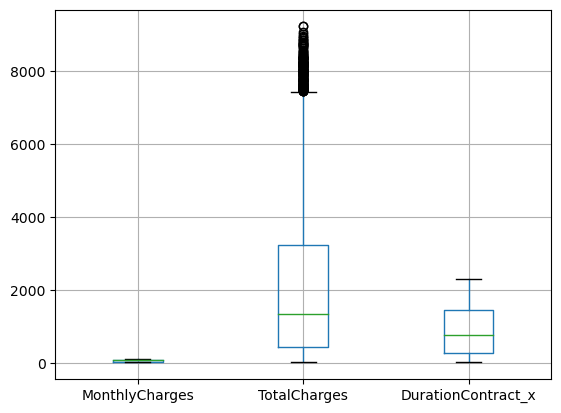

In [31]:
data.boxplot()

In [32]:
data  = data.loc[data['TotalCharges'] <= 7500]
data.shape

(6851, 20)

In [33]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'DurationContract_x']


,gender,SeniorCitizen,Partner,Dependents,BeginDate_x,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DurationContract_x
gender,1.00,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.01,0.00,0.03,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.00,1.00,0.02,0.32,0.05,0.09,0.09,0.24,0.30,0.31,0.14,0.16,0.05,0.10,0.09,0.10,0.16,0.19,0.22,0.07
Partner,0.00,0.02,1.00,0.66,0.46,0.19,0.17,0.03,0.23,0.17,0.37,0.01,0.20,0.20,0.21,0.16,0.17,0.16,0.20,0.44
Dependents,0.00,0.32,0.66,1.00,0.20,0.06,0.15,0.17,0.22,0.19,0.10,0.11,0.11,0.02,0.00,0.09,0.03,0.07,0.04,0.20
BeginDate_x,0.02,0.05,0.46,0.20,1.00,0.56,0.77,0.09,0.45,0.37,0.77,0.23,0.37,0.41,0.42,0.36,0.32,0.33,0.40,0.98
EndDate,0.02,0.09,0.19,0.06,0.56,1.00,0.31,0.07,0.18,0.24,0.24,0.14,0.15,0.22,0.22,0.13,0.18,0.20,0.23,0.39
Type,0.00,0.09,0.17,0.15,0.77,0.31,1.00,0.12,0.28,0.36,0.44,0.55,0.14,0.08,0.12,0.17,0.05,0.05,0.05,0.62
PaperlessBilling,0.00,0.24,0.03,0.17,0.09,0.07,0.12,1.00,0.37,0.47,0.20,0.23,0.00,0.19,0.15,0.04,0.34,0.32,0.24,0.06
PaymentMethod,0.01,0.30,0.23,0.22,0.45,0.18,0.28,0.37,1.00,0.39,0.33,0.33,0.24,0.26,0.29,0.25,0.37,0.37,0.33,0.34
MonthlyCharges,0.00,0.31,0.17,0.19,0.37,0.24,0.36,0.47,0.39,1.00,0.62,0.92,0.53,0.60,0.63,0.54,0.82,0.82,0.65,0.33


In [34]:
%matplotlib inline

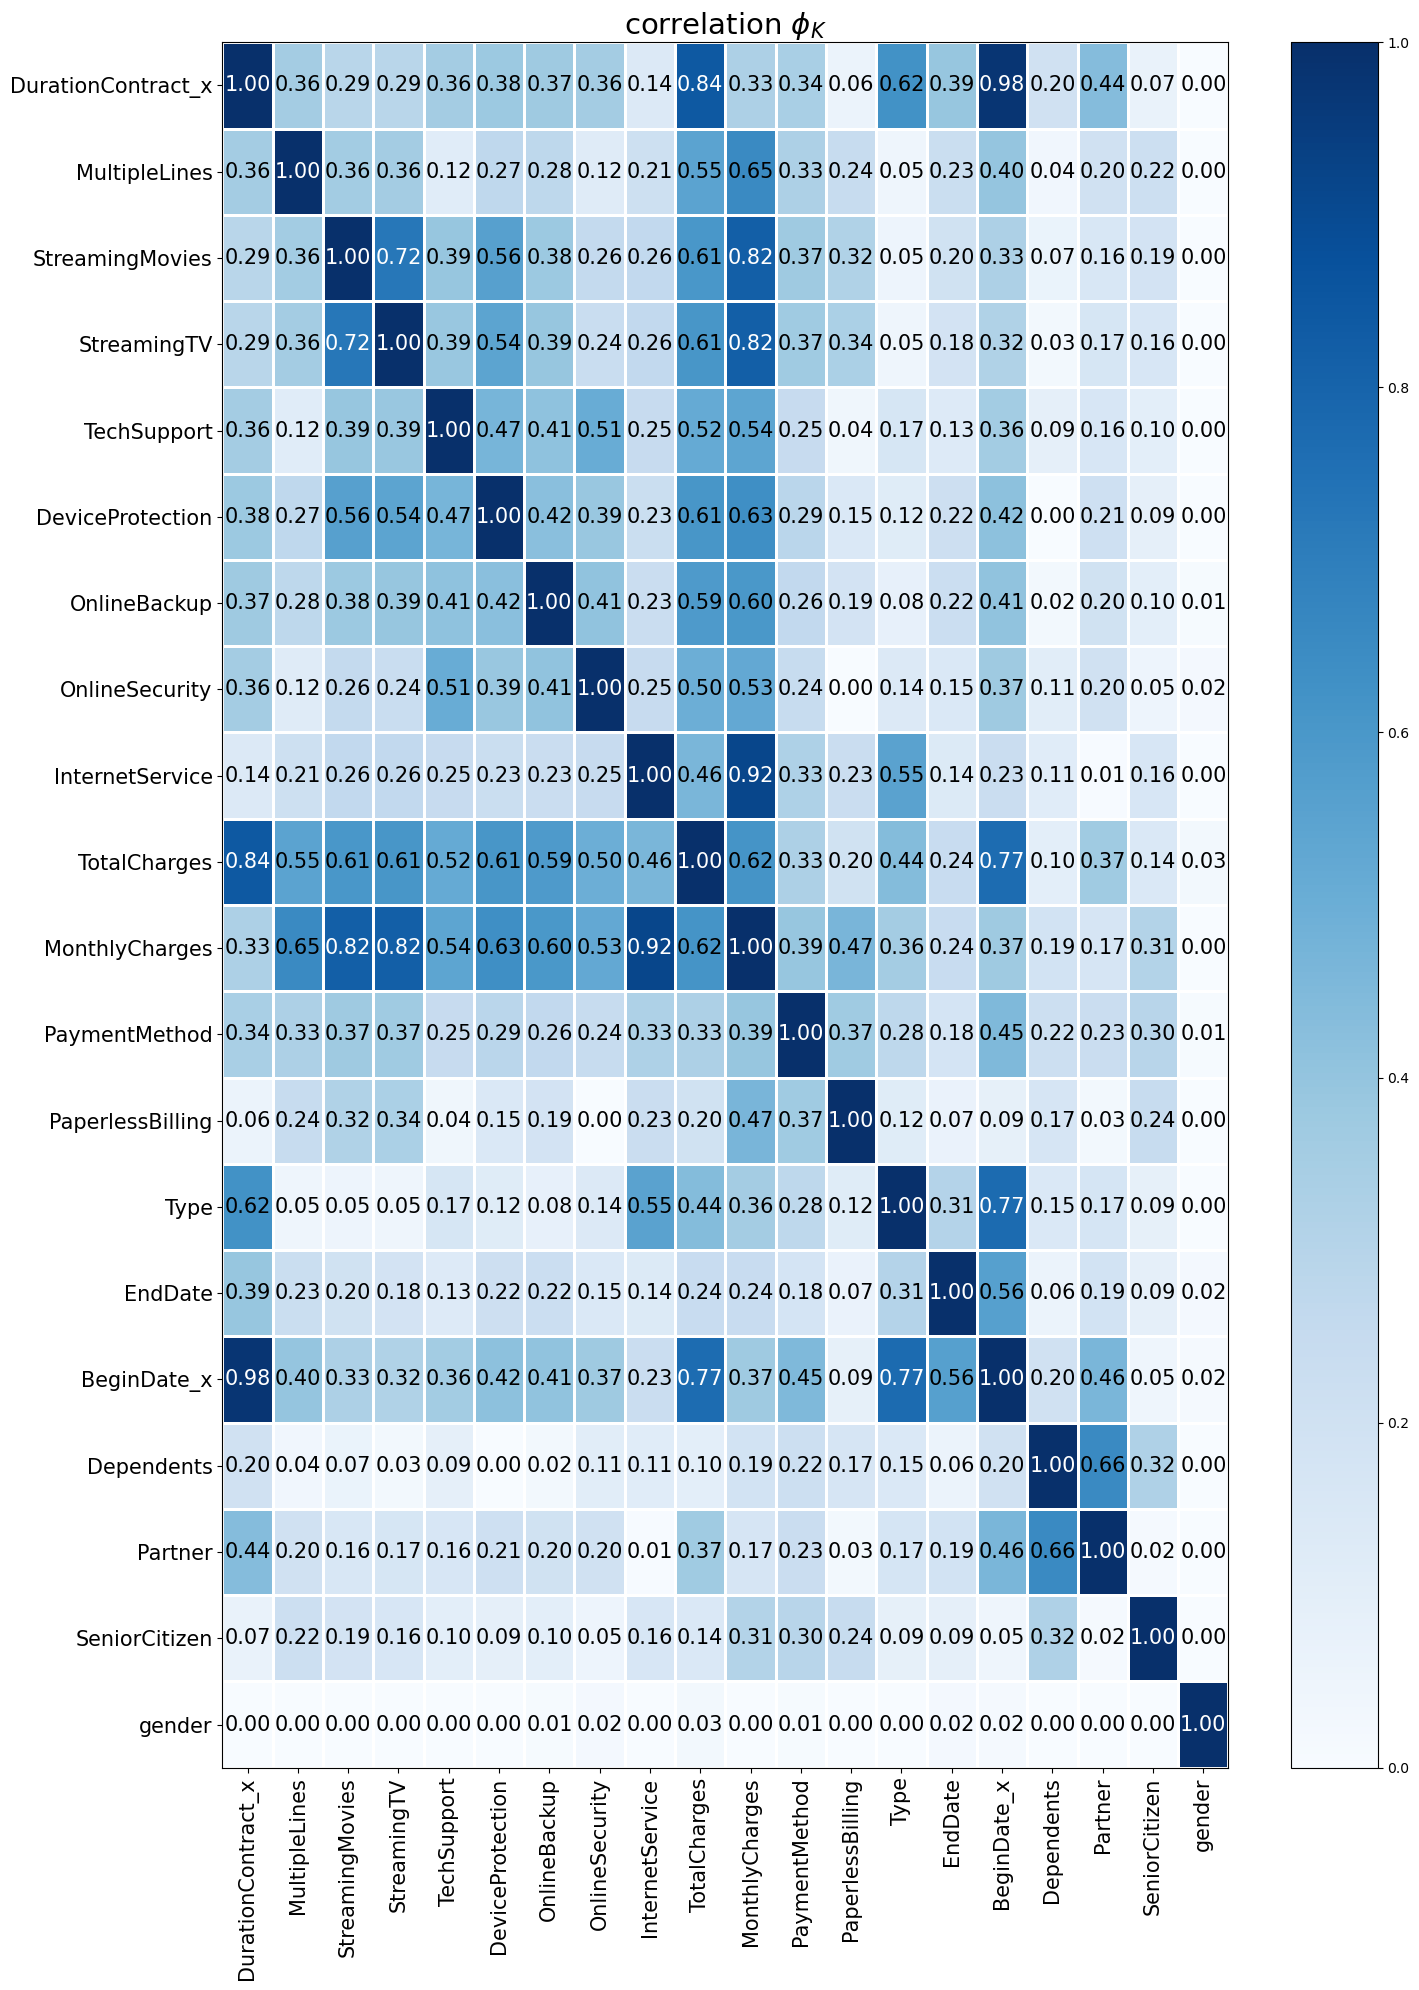

In [35]:



plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15,20))
plt.tight_layout()


У нас есть некоторые признаки, значение которых сильно зависит от величины других. Это явление мультиколлинеарности и от него лучше избавиться, лишние признаки не нужны модели. Лишняя информация может повлиять в негативном ключе на качество предсказаний. 

- В первую очередь, мы можем удалить столбец с датой начала контракта, поскольку у нас уже есть DurationContract, следовательно, когда именно началось действи еокнтракта уже не так важно. 


- Вызывает подозрения признак Gender, тк он не связан абсолютно ни с одним другим признаком. Сложно представить, что пол клиента может влиять на пользование услугами и желание разорвать контракт. Поэтому удаление этого признака не должно повлиять на работу модели, он не несет в себе ценнной информации. 









In [36]:
significance_overview = data.significance_matrix()
significance_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'DurationContract_x']


,gender,SeniorCitizen,Partner,Dependents,BeginDate_x,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DurationContract_x
gender,97.24,-1.38,-0.87,-0.07,0.24,0.34,-0.99,0.53,0.33,0.09,0.71,-0.46,1.14,0.70,-1.34,0.13,-0.34,0.26,-0.19,-0.55
SeniorCitizen,-1.38,77.55,0.94,19.06,1.17,1.80,12.56,13.34,16.62,19.91,7.90,23.06,2.83,5.16,4.78,5.34,8.46,9.69,11.68,3.11
Partner,-0.87,0.94,97.16,38.55,29.05,9.52,23.49,1.44,12.51,9.71,22.99,0.53,10.62,10.36,11.13,8.60,8.79,8.29,10.66,27.73
Dependents,-0.07,19.06,38.55,91.05,9.62,1.23,19.85,9.04,12.07,10.77,5.02,15.39,5.85,1.32,0.15,4.73,1.43,3.53,1.87,11.76
BeginDate_x,0.24,1.17,29.05,9.62,195.63,11.13,56.78,2.46,27.94,21.12,81.25,7.54,21.96,24.89,25.84,21.28,18.78,19.64,24.28,139.11
EndDate,0.34,1.80,9.52,1.23,11.13,105.18,11.88,2.09,7.31,6.64,9.28,3.63,5.25,10.81,10.40,4.28,8.43,9.23,11.80,20.24
Type,-0.99,12.56,23.49,19.85,56.78,11.88,116.01,15.88,31.82,25.56,33.77,27.88,18.85,11.08,16.22,22.31,6.50,6.99,6.08,54.76
PaperlessBilling,0.53,13.34,1.44,9.04,2.46,2.09,15.88,96.15,20.41,29.34,11.51,31.53,0.54,9.88,7.76,2.11,18.24,17.26,13.13,2.64
PaymentMethod,0.33,16.62,12.51,12.07,27.94,7.31,31.82,20.41,136.47,35.09,27.97,37.70,12.97,14.49,16.04,13.24,21.19,21.24,18.54,29.24
MonthlyCharges,0.09,19.91,9.71,10.77,21.12,6.64,25.56,29.34,35.09,169.03,58.46,104.75,37.73,43.16,45.17,38.61,59.25,59.13,44.24,23.70


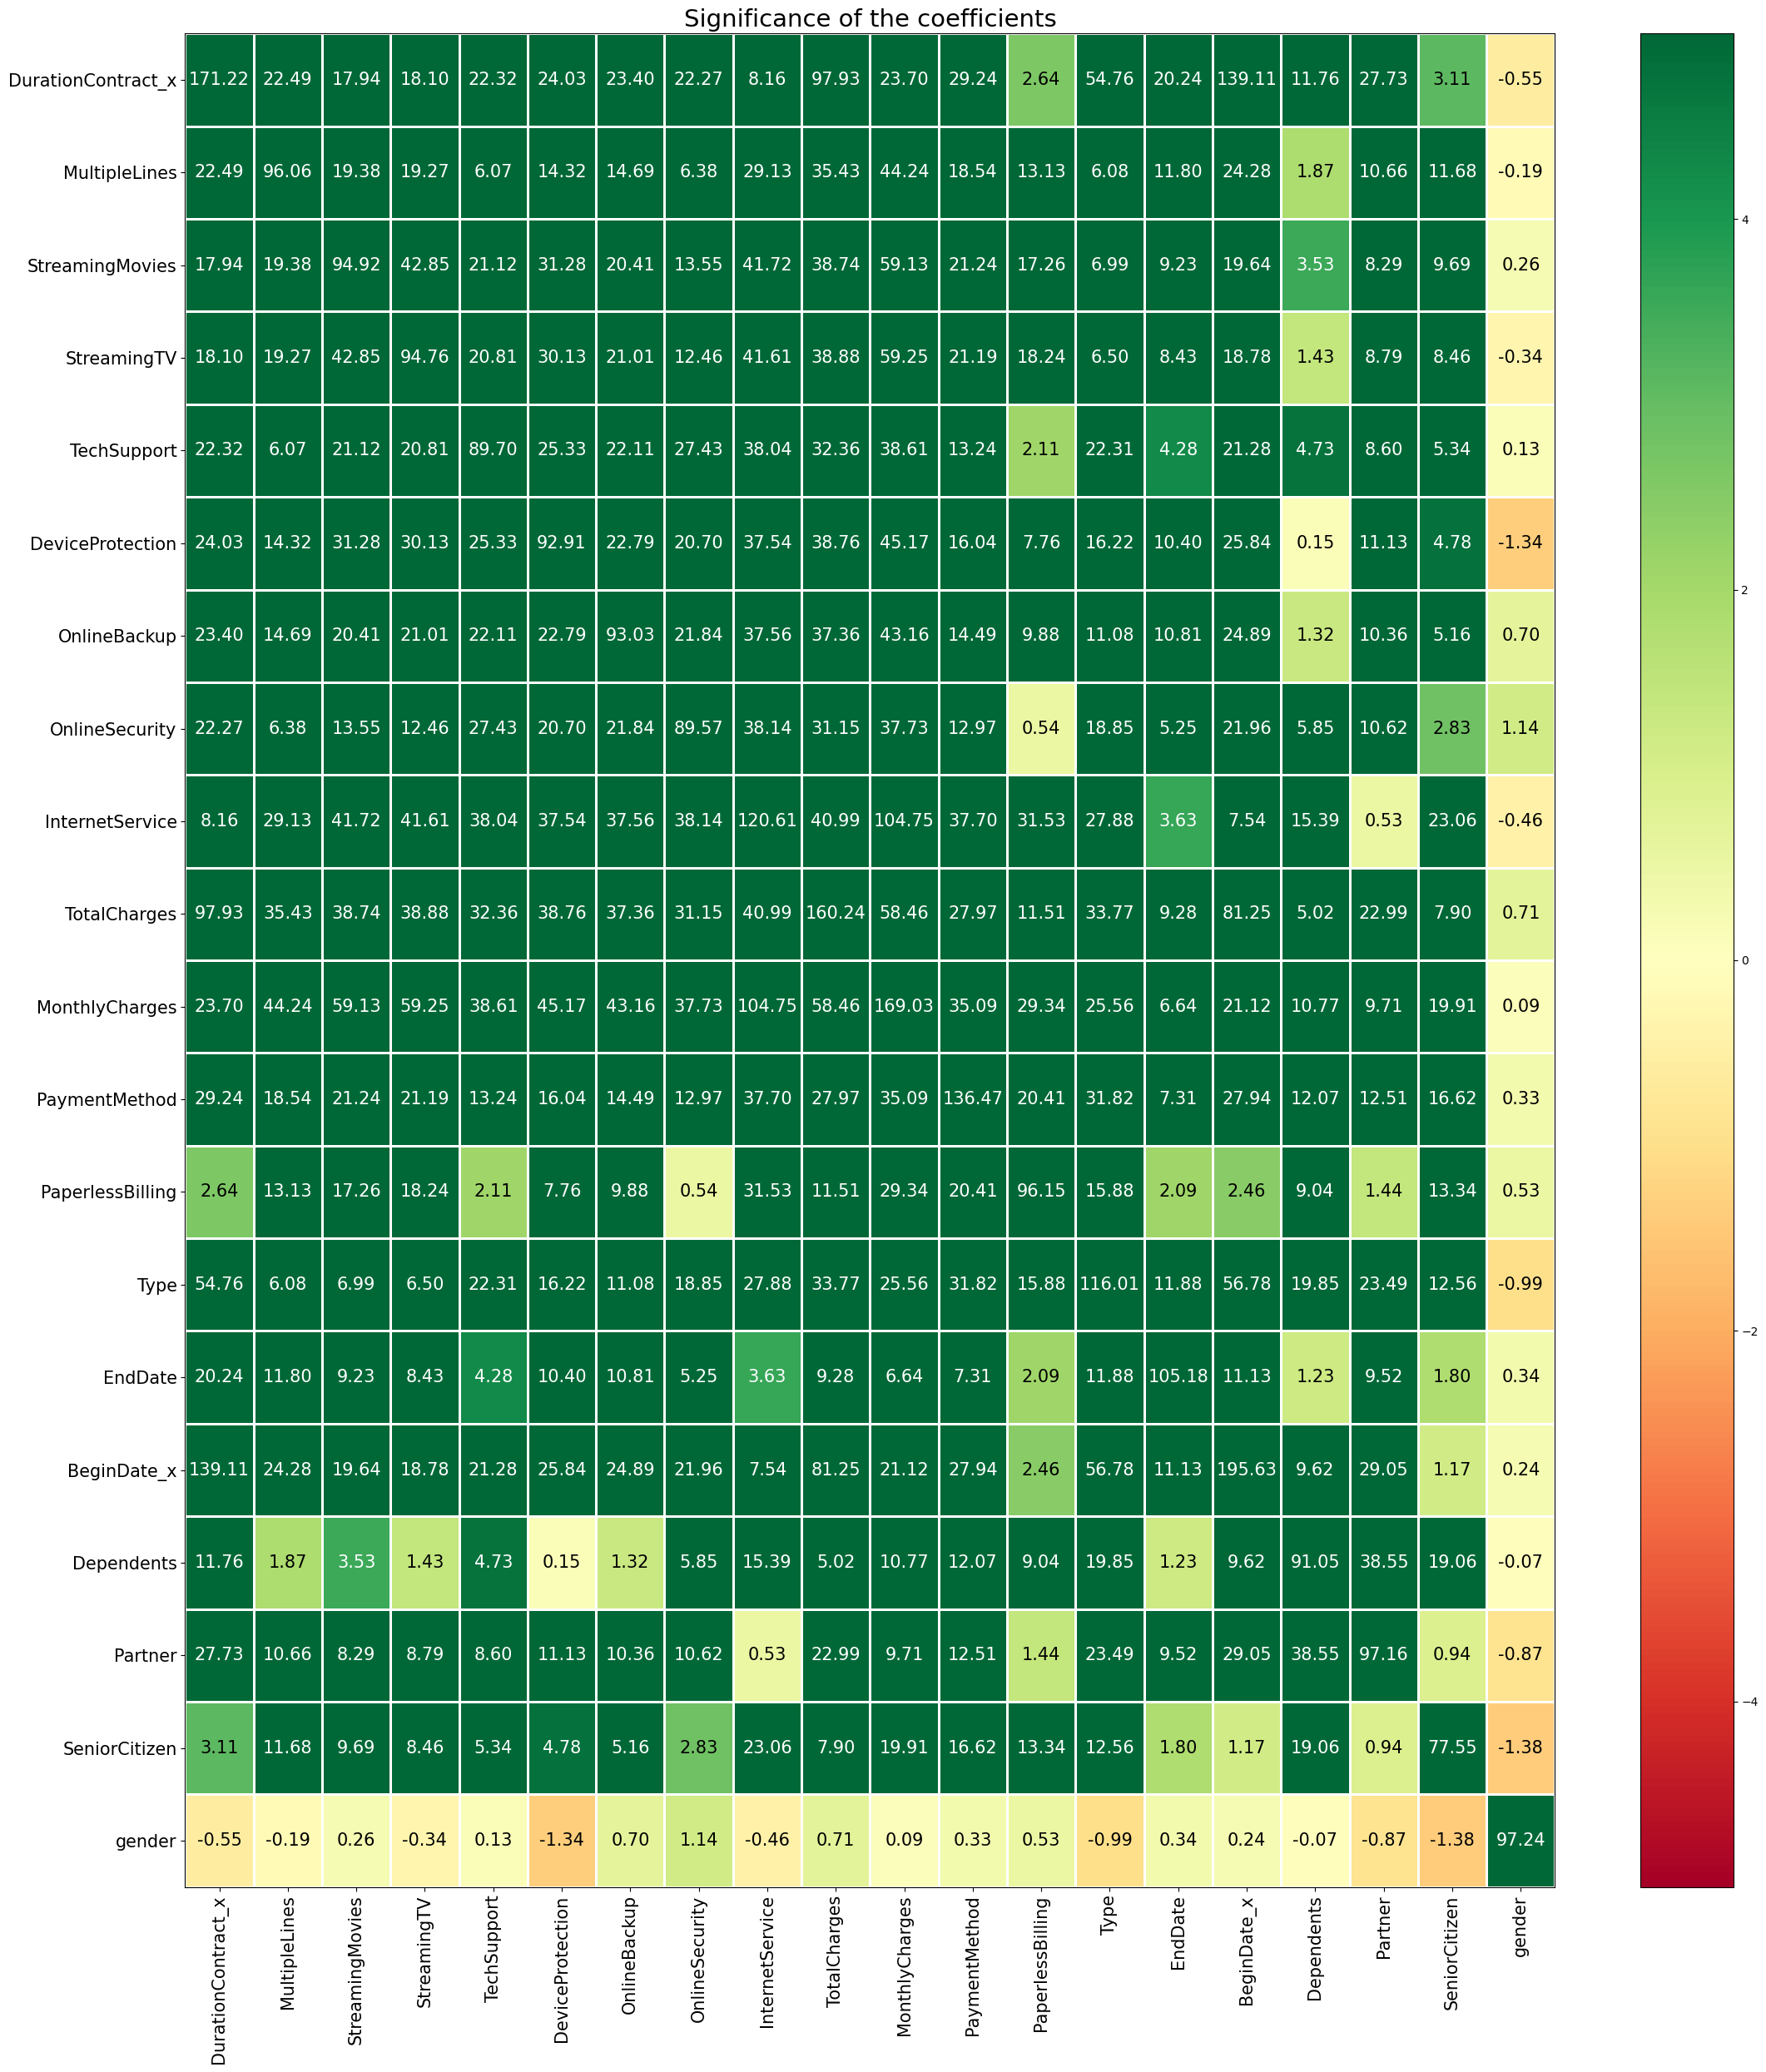

In [37]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(23, 25))
plt.tight_layout()

Еще раз можно убедиться по графику ваджности признаков, что пол клиента не является ценной информацией.

In [38]:
data = data.drop(columns=['BeginDate_x', 'gender']) 


In [39]:
data.shape

(6851, 18)

Создадим столбец с единичками (если дата окончания указана,т.е. если контракт закончился) и нулями (если конракт еще действует)

In [40]:
data['EndDate_bool'] = 0
data.loc[data['EndDate'] != 'No','EndDate_bool'] = 1
data.head(50)

,SeniorCitizen,Partner,Dependents,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DurationContract_x,EndDate_bool
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,0,No,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,1036,0
3668-QPYBK,0,No,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,123,0
7795-CFOCW,0,No,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
9237-HQITU,0,No,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,153,0
9305-CDSKC,0,No,No,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337,0
1452-KIOVK,0,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Fiber optic,No,Yes,No,No,Yes,No,Yes,671,0
6713-OKOMC,0,No,No,No,Month-to-month,No,Mailed check,29.75,300.48,DSL,Yes,No,No,No,No,No,No,306,0
7892-POOKP,0,Yes,No,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945,0


In [41]:
data = data.drop(columns='EndDate')

Проверим выборку на дисбаланс

In [42]:
data['EndDate_bool'].value_counts()

0    5753
1    1098
Name: EndDate_bool, dtype: int64

Text(0.5, 1.0, 'The contract is opened/closed')

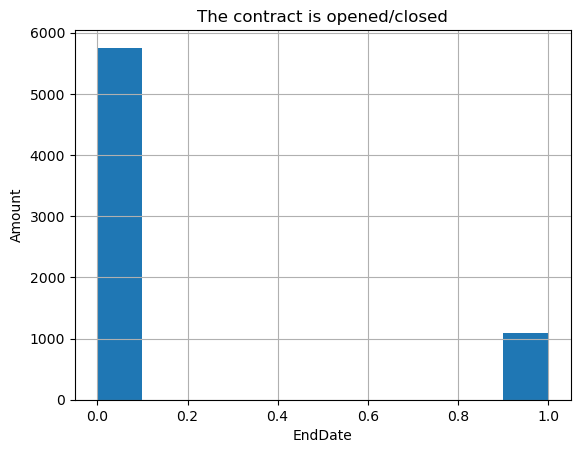

In [43]:
data['EndDate_bool'].hist();
plt.xlabel('EndDate', fontsize=10)
plt.ylabel('Amount', fontsize=10)
plt.title('The contract is opened/closed', fontsize=12)




Дисбаланс присутсвует, людей с действующим контрактом гораздо (примерно в пять раз) больше. Мы не будем ничего предпренимать, тк наша метрика не чувствительна к дисбалансу классов.

In [44]:
def build_graph(column):
    plt.figure(figsize=(10,5))
    sns.histplot(data.loc[data['EndDate_bool'] == 1][column], alpha=0.8, color='green', label='left');
    sns.histplot(data.loc[data['EndDate_bool'] == 0][column], alpha =0.3, color = 'purple', label='stayed');
    plt.legend()
    plt.title(f'{column} as the reason for leaving')



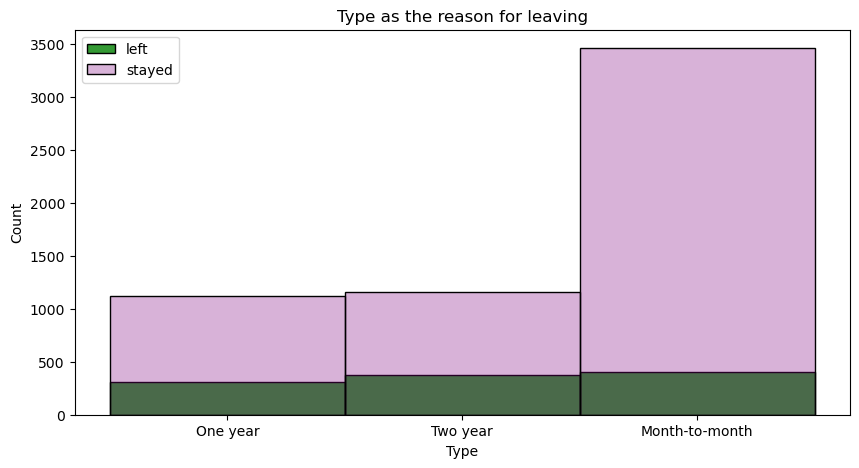

In [45]:
build_graph('Type')

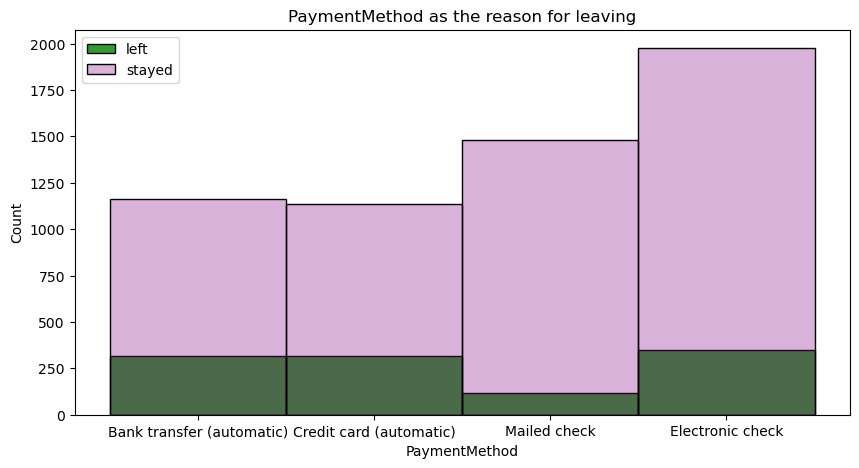

In [46]:
build_graph('PaymentMethod')

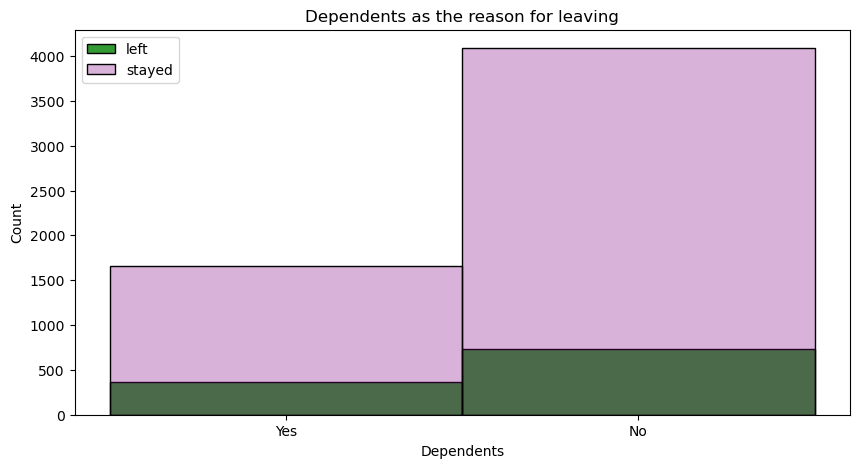

In [47]:
build_graph('Dependents')

**Мини-вывод:** 
- Есть ли у клиента зависящие от него финансово люди, на первый взгляд, не влияет на прекращение контракта. Прослеживается связь между PaymentMethod и уходом киента. 
- Среди ушедших очень мало людей, использовавших Mailed Check, хотя среди продолжающих пользоваться услгами таких людей много. 
- Тип оплаты среди ушедших примерно одинаковый, однако среди оставшихся клиентов сильно преобладает метод 'Month-to-month'

## Создание модели

In [48]:
#data = data.reset_index(inplace=True, drop=True)

In [49]:
X = data.drop(['EndDate_bool'], axis=1)
y = data['EndDate_bool']
X

,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DurationContract_x
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,0,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,0,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,730
2234-XADUH,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2191
4801-JZAZL,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,DSL,Yes,No,No,No,No,No,No,337


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [51]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [52]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

num_columns = numerical_columns_selector(data)
cat_columns = categorical_columns_selector(data)
num_columns.remove('EndDate_bool')
num_columns

['MonthlyCharges', 'TotalCharges', 'DurationContract_x']

In [53]:
cat_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [54]:
num_pipline = Pipeline([('scaler', StandardScaler())])

columns_pipeline=ColumnTransformer([('num_cols', num_pipline, num_columns),
                                    ('category_encoder',
                                        OrdinalEncoder(), cat_columns)])
columns_pipeline

ColumnTransformer(transformers=[('num_cols',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['MonthlyCharges', 'TotalCharges',
                                  'DurationContract_x']),
                                ('category_encoder', OrdinalEncoder(),
                                 ['SeniorCitizen', 'Partner', 'Dependents',
                                  'Type', 'PaperlessBilling', 'PaymentMethod',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'MultipleLines'])])

Добавила DropCorrelatedFeatures(). Эта функция может заметить то, чего не заметила я, лишней такая обработка данных не будет:)

In [55]:
pipeline = make_pipeline(columns_pipeline)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DurationContract_x']),
                                                 ('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])]))])

### LogisticRegression

In [56]:
pipeline.steps.append(('mod', LogisticRegression()))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DurationContract_x']),
                                                 ('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('mod', LogisticRegression())])

In [57]:
params_LR = [{
        'mod__class_weight': [None, 'balanced'],
        'mod__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        
    }]

grid_LR = RandomizedSearchCV(pipeline,
                    params_LR,
                    n_iter=10,
                    cv=3,
                    verbose=1,
                    random_state=RANDOM_STATE,
                    scoring='roc_auc',
                    n_jobs=-1)

In [58]:
%%time

grid_LR.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 670 ms, sys: 85.3 ms, total: 755 ms
Wall time: 2.47 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_cols',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'DurationContract_x']),
                                                                              ('category_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'MultipleLines'])])),
                                             ('mod', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'mod__class_weight': [None,
                                                               'balanced'],
                                         'mod__solver': ['newton-cg', 'lbfgs',
                                                         'liblinear', 'sag',
                                                         'saga']}],
                   random_state=240423, scoring='roc_auc', verbose=1)

In [59]:
#sklearn.metrics.get_scorer_names()

In [60]:
grid_LR.best_score_

0.7552772015433966

In [61]:
model_LR = grid_LR.best_estimator_

In [62]:
grid_res = pd.DataFrame(grid_LR.cv_results_).sort_values(by='rank_test_score')

In [63]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(0.22946969668070474, 0.06132920583089193)

In [64]:
LR_fit_time = grid_res.iloc[0]['mean_fit_time']
LR_score_time = grid_res.iloc[0]['mean_score_time']

In [65]:
pipeline.steps.pop(1)
#pipeline

('mod', LogisticRegression())

### RandomForest

In [66]:
pipeline.steps.append(('mod', RandomForestClassifier()))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DurationContract_x']),
                                                 ('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('mod', RandomForestClassifier())])

In [67]:
params_RF = [{
        'mod__n_estimators': range(2,500, 5),
        'mod__max_depth': range(5,250, 5),
        
    }]

grid_RF = RandomizedSearchCV(pipeline,
                    params_RF,
                    n_iter=50,
                    cv=5,
                    verbose=1,
                    random_state=RANDOM_STATE,
                    scoring='roc_auc',
                    n_jobs=-1)

In [68]:
%%time

grid_RF.fit(X_train, y_train)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: user 8.14 s, sys: 464 ms, total: 8.6 s
Wall time: 3min 28s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_cols',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'DurationContract_x']),
                                                                              ('category_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'MultipleLines'])])),
                                             ('mod',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'mod__max_depth': range(5, 250, 5),
                                         'mod__n_estimators': range(2, 500, 5)}],
                   random_state=240423, scoring='roc_auc', verbose=1)

In [69]:
model_RF = grid_RF.best_estimator_

In [70]:
grid_RF.best_score_


0.8290508367740372

In [71]:
grid_res = pd.DataFrame(grid_RF.cv_results_).sort_values(by='rank_test_score')

In [72]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(9.030504846572876, 0.41059279441833496)

In [73]:
RF_fit_time = grid_res.iloc[0]['mean_fit_time']
RF_score_time = grid_res.iloc[0]['mean_score_time']

In [74]:
pipeline.steps.pop(1)
#pipeline

('mod', RandomForestClassifier())

### CatBoostClassifier

In [75]:
pipeline.steps.append(('mod', CatBoostClassifier()))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DurationContract_x']),
                                                 ('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('mod',
                 <catboost.core.CatBoostClassifier object at 0x7fc440cbc280>)])

In [76]:
params_CB = [{'mod__learning_rate': [0.01,0.03, 0.05, 0.1, 0.5,0.7],
        'mod__depth': [4, 6, 10, 15,20],
        'mod__l2_leaf_reg': [1, 3, 5, 7, 9],
        'mod__n_estimators': range(5,50,5)
    }]

grid_CB = RandomizedSearchCV(pipeline,
                    params_CB,
                    n_iter=150,
                    cv=5,
                    verbose=0,
                    random_state=RANDOM_STATE,
                    scoring='roc_auc')

In [77]:
%%time

grid_CB.fit(X_train, y_train)

0:	learn: 0.6772769	total: 55.4ms	remaining: 776ms
1:	learn: 0.6629220	total: 73.8ms	remaining: 479ms
2:	learn: 0.6498554	total: 76.3ms	remaining: 305ms
3:	learn: 0.6365216	total: 98.3ms	remaining: 270ms
4:	learn: 0.6235140	total: 108ms	remaining: 217ms
5:	learn: 0.6110039	total: 130ms	remaining: 195ms
6:	learn: 0.5992582	total: 154ms	remaining: 176ms
7:	learn: 0.5881746	total: 159ms	remaining: 139ms
8:	learn: 0.5777632	total: 183ms	remaining: 122ms
9:	learn: 0.5683419	total: 212ms	remaining: 106ms
10:	learn: 0.5598206	total: 234ms	remaining: 85.1ms
11:	learn: 0.5505119	total: 257ms	remaining: 64.2ms
12:	learn: 0.5413517	total: 261ms	remaining: 40.2ms
13:	learn: 0.5329500	total: 282ms	remaining: 20.1ms
14:	learn: 0.5248683	total: 307ms	remaining: 0us
0:	learn: 0.6775730	total: 10.4ms	remaining: 145ms
1:	learn: 0.6632788	total: 32.4ms	remaining: 210ms
2:	learn: 0.6501568	total: 35ms	remaining: 140ms
3:	learn: 0.6378722	total: 58.8ms	remaining: 162ms
4:	learn: 0.6249645	total: 69.9ms	rem

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num_cols',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'DurationContract_x']),
                                                                              ('category_encoder',
                                                                               OrdinalEncoder(),
                                                                               ['SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'InternetServi...
                                                                                'TechSupport',
                                                                                'StreamingTV',
                                                                                'StreamingMovies',
                                                                                'MultipleLines'])])),
                                             ('mod',
                                              <catboost.core.CatBoostClassifier object at 0x7fc440cbc280>)]),
                   n_iter=150,
                   param_distributions=[{'mod__depth': [4, 6, 10, 15, 20],
                                         'mod__l2_leaf_reg': [1, 3, 5, 7, 9],
                                         'mod__learning_rate': [0.01, 0.03,
                                                                0.05, 0.1, 0.5,
                                                                0.7],
                                         'mod__n_estimators': range(5, 50, 5)}],
                   random_state=240423, scoring='roc_auc')

In [78]:
model_CB = grid_CB.best_estimator_
model_CB

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'DurationContract_x']),
                                                 ('category_encoder',
                                                  OrdinalEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'Type',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'MultipleLines'])])),
                ('mod',
                 <catboost.core.CatBoostClassifier object at 0x7fc440bdfd30>)])

In [79]:
grid_CB.best_score_


0.8576732363341751

In [80]:
grid_res = pd.DataFrame(grid_CB.cv_results_).sort_values(by='rank_test_score')

In [81]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(0.19608068466186523, 0.029047107696533202)

In [82]:
CB_fit_time = grid_res.iloc[0]['mean_fit_time']
CB_score_time = grid_res.iloc[0]['mean_score_time']

In [83]:
pipeline.steps.pop(1)

('mod', <catboost.core.CatBoostClassifier at 0x7fc440cbc280>)

In [84]:
d = {"score":pd.Series([grid_LR.best_score_, grid_RF.best_score_, grid_CB.best_score_], index=['LR', 'RF', 'CB']),
   ...: "FitTime": pd.Series([LR_fit_time,RF_fit_time,CB_fit_time], index=['LR', 'RF', 'CB']),
   ...: 'ScoreTime': pd.Series([LR_score_time,RF_score_time,CB_score_time], index=['LR', 'RF', 'CB'])}
df1 = pd.DataFrame(d)
display(df1)

,score,FitTime,ScoreTime
LR,0.755277,0.229470,0.061329
RF,0.829051,9.030505,0.410593
CB,0.857673,0.196081,0.029047


Лучшая модель   **CatboostClassifier**

### Проверка на тестовой выборке

In [85]:
predictions = model_CB.predict_proba(X_test)

In [86]:
predictions


array([[0.96734708, 0.03265292],
       [0.99255984, 0.00744016],
       [0.74377939, 0.25622061],
       ...,
       [0.96711587, 0.03288413],
       [0.85333662, 0.14666338],
       [0.72547508, 0.27452492]])

In [87]:
metrics = roc_auc_score(y_test, predictions[:,1])
metrics

0.8736060184599823

In [88]:
imp = pd.Series(grid_CB.best_estimator_.named_steps['mod'].feature_importances_, index=grid_CB.best_estimator_.named_steps['columntransformer'].get_feature_names_out())
imp

num_cols__MonthlyCharges               7.904482
num_cols__TotalCharges                 7.271179
num_cols__DurationContract_x          41.638027
category_encoder__SeniorCitizen        1.722239
category_encoder__Partner              3.801174
category_encoder__Dependents           1.287255
category_encoder__Type                13.687798
category_encoder__PaperlessBilling     1.318432
category_encoder__PaymentMethod        5.036530
category_encoder__InternetService      1.421981
category_encoder__OnlineSecurity       0.404844
category_encoder__OnlineBackup         3.065783
category_encoder__DeviceProtection     2.805745
category_encoder__TechSupport          1.313788
category_encoder__StreamingTV          1.139138
category_encoder__StreamingMovies      2.414734
category_encoder__MultipleLines        3.766871
dtype: float64

Text(0.5, 0, 'Importance')

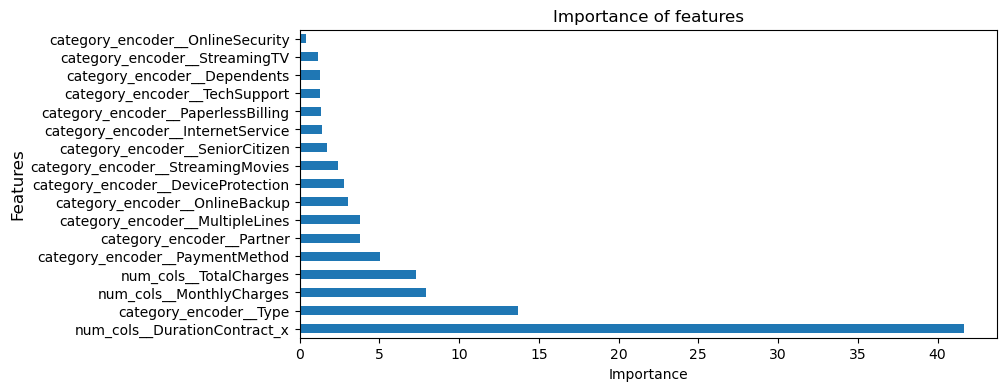

In [89]:
plt.title('Importance of features')

plt.ylabel('Features', fontsize=12)
imp.nlargest(20).plot(kind='barh', figsize = (9,4));
plt.xlabel('Importance')

Сильная зависимость присутсвует между длительностью контракта и уходом клиента. Как мы и предположили в начале, признак Type оказался действительно важным для опредления лояльности клиента. Также достаточно важно, какую сумму платит клиент ежемесячно. Имеют значению такие признаки как наличие партнера и метод оплаты услуг. 

In [90]:
pred = model_CB.predict(X_test)

In [91]:
conf_m = confusion_matrix(y_test, pred)
conf_m

array([[1391,   47],
       [ 164,  111]])

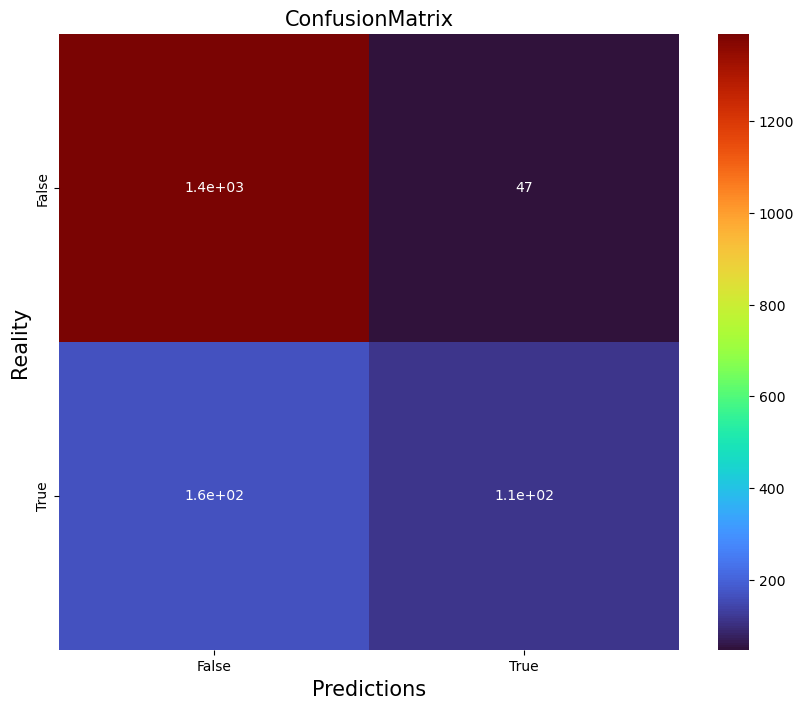

In [92]:
plt.figure(figsize=(10,8))
mp = sns.heatmap(conf_m, annot=True, cmap="turbo")

mp.set_title('ConfusionMatrix',fontsize=(15));
mp.set_xlabel('Predictions', fontsize=(15));
mp.set_ylabel('Reality',fontsize=(15));

mp.xaxis.set_ticklabels(['False', 'True']);
mp.yaxis.set_ticklabels(['False', 'True']);

Наша модель успешно предсказывает истинно отрицательные результаты, т.е. случай, когда клиент продолжает оплачивать услуги и пользоваться ими. Истинно положительных ответов больше чем ложно положительных, т.е. модель вполне справляется с предсказыванием ухода клиента от компании. Случаев положительных гораздо меньше в выборке, с эти и связана не идельная точность модели

## Отчет

- Какие пункты плана были выполнены, а какие — нет. Почему?

*Выполнены все пункты плана*

- Какие трудности возникли и как вы их преодолели?

*Было достаточно сложно достигнуть хорошей метрики (больше 0.85), поскольку сначала я удалила некоторые из кореллирующих между собой признаков (те, чей коэффицент корелляции был больше 0.6), но этого делать не стоило, тк чем меньше признаков, тем сложнее модели обучаться, тем более что все-таки 0.6 можно считать не супер высоким коэффицентом.* 

*Также столкнулась с недостатком оперативной памяти моего компьютера, поскольку в планах было использовать бустинговую модель LightGBM, но ядро не выдерживало и умирало. Не считаю это огромной потерей, поскольку удалось воспользоваться другой бустинговой моделью Catboost, которая по качеству и скорости предсказаний почти не отличается.*


- Какие ключевые шаги в решении задачи вы выделили?

*Самыми важными этапами я считаю **предобработку данных**, т.е. приведение данных у нужному типу, обьеденение датафреймов, создание допольнительных признаков. Далее, **построение пайплайна и обучение моделей**. Поскольку подбор гиперпарамтеров я делала через GridSearchCV, то пайплайн был необходим,тк в случае его отсуствия происходила бы утечка данных из train  в test, и я не смогла бы выбрать лучшие параметры и модель. В финале работы неоходимо было **протестировтаь выбранную лучшую модель на тестовых данных**, чтобы получить окончательную метрику.*
- Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

*Признаки:*
 
SeniorCitizen - наличие пенсионного статуса

Partner - наличие супруга

Dependents - наличие иждивенцев

Type - тип оплаты услуг (каждый месяц, раз в месяц)

PaperlessBilling	-  электронный чек или бумажный

PaymentMethod - способ оплаты

MonthlyCharges - клиент ежемесячно платит

TotalCharges - всего потрачено на услуги

InternetService - интернет подключение может быть двух типов: через телефонную линию (DSL, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*)

DeviceProtection - антивирус

OnlineSecurity - блокировка небезопасных сайтов 

TechSupport - выделенная линия технической поддержки

OnlineBackup - облачное хранилище файлов для резервного копирования данных

StreamingTV  - стриминговое телевидение

StreamingMovies - каталог фильмов 

MultipleLines - возможность вести звонки на параллельных линиях

Эти признаки были разделены на категориланые и числовые. Категориальные были закодированы OneHotEncoder, а числовые были отмасштабированы при помощи Scaler. 

- Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Лучшей моделью оказалась CatBoostClassifier с парматерами:

{'mod__n_estimators': 40,
 'mod__learning_rate': 0.5,
 'mod__l2_leaf_reg': 1,
 'mod__depth': 6}

**Что можно сделать, чтобы уменьшить кол-во уходящий клиентов?**

Как было выяснено в ходе исследования, метод оплаты и тип оплаты имеют некоторое влияние на лояльность клиента. Выше было показано, что среди оставшихся клиентов превалирует тип оплаты ежемесячный, в то время как среди ушедших все типы оплаты одинаково популярны. Следовательно, желание продолжить пользоваться услугами больше у людей оплачивающих счет каждый меясц, поэтому можно при выборе ежемесячной оплаты предлагать клиентам небольшую дополнительную скидку. 